# we want to see if we can weight mlm to be in like known functionally relevant regions

In [22]:
#First have to modify mask to ensure that we upweight certain regions
import numpy as np
import zarr
import os
import torch
import pandas as pd
from random import random
import json

def mask_seq(seq, mask_pct=0.15, replace_with_N=True, span=1, stype='category', weights=None, upweight_fraction=0.95, mask_only=False, mask_tie=1, independent_tracks=False, max_scale=3, binary_score_threshold=None, neg_maskrate=None, max_neg_to_pos_ratio=0.5, log_weights=False):
    """This function will mask the sequence data, it does the BERT masking where you do 80% truly masked, 10% random, 10% unchanged
    Note that for random replacement, it cannot be the N token, sicne it's very rare anyways, always random nucleotide!
    Args:
        seq: the sequence to mask, this is a tensor of shape (length, N) if categorical, or (length,1) if continuous, N is the number of classes (5 for ohe nucleotide data)
        mask_pct: the percentage of the sequence to mask, default is 0.15 or 15%
        replace_with_N: whether to allow random replacement of values with N (for one hot encoded data). Keep True for other categorical data
        span: the size of the span to mask, default is 1, so it masks every element independently, but can be larger to mask chunks of size span
        stype: the type of sequence, 'category' for categorical like ohe nucleotide data and 'continuous' for continuous like raw accessibility data, default is 'category'
        weights: the weights to use for weighting regions like peaks. default is None, must be a tensor of shape (length,) to weight the peaks higher for masking. can be the same as the seq itself, and can be a binary tensor
        weight_min: the minimum weight to use for weighting, i.e what a value of 0 weight does to the probability, default is 0.3
        weight_max: the maximum weight to use for weighting, i.e what a value of 1 weight does to the probability, default is 3
        mask_only: whether to do the 10% unchanged and 10% random replacement, default is False. If True, will only do the 100% truly masked and leave the rest unchanged
        mask_tie: how much masking is tied across categories. 1 means fully tied, so all tracks are masked the same, 0 means fully indepdendent masking across categories. If true, returns slightlly different values
        independent_tracks: whether to mask independent tracks separately, only used if stype is 'category' and mask_tie is 0. If True, masks each track independently, if False, masks all tracks the same
        max_scale: the maximum scaling factor for continuous weights, default is 3, so prob of 0.15 can at most be 0.45
        binary_score_threshold: the threshold to use for binary weights, only used if weights are provided. If provided, weights above this threshold are considered positive class, below are negative class
        neg_maskrate: the negative class mask rate, only used if weights are provided and binary weights are used. If None, will default to 1/10 of the positive class mask rate
        max_neg_to_pos_ratio: the maximum percentage of negative elements to mask relatived to positive. So 0.5 means can mask 1 negative for every 2 positives. Only used if weights are provided and binary weights are used
    Returns:
        seq: the masked sequence, this is a tensor of shape (length, N+1) or N*2 if mask_tie is less than 1 if categorical or (length, 2) if continuous, where the last column is the mask track (only tells if masked, some are random or unchanged)
        seq_unmask: the unmasked sequence, this is a tensor of shape (length, N+1) or N*2 if categorical or (length, 2), where the last column is the mask track (tells all elements that have been changed or goign to evaluate)
    """
    
    if len(seq.shape) == 1: #if it's just a 1D tensor, we need to add a dimension for the mask track
        seq = seq.unsqueeze(1) #so now it's shape length x 1, so we can concatenate other things
    
    extra_append = 0
    if seq.shape[0]%span != 0:
        #we append on values
        remainder = seq.shape[0] % span
        extra_append = span - remainder
        seq = torch.cat([seq, torch.zeros((extra_append,seq.shape[1]), dtype=torch.float)]) #so now we can have a mask for every element in the span, so size length again
    num_elements = seq.shape[0]//span #chunks into chunks of size span

    # Create a probability vector (one per token) and sample which tokens to mask
    probability_matrix = torch.full((num_elements,), mask_pct, dtype=torch.float64) #size of length, defines for each element if we mask it or not
    
    #we can also weight some regions like peaks more
    if weights is not None:
        assert mask_tie == 1, "Weighting with weights is only supported for mask_tie=1 currently"
        weights = weights.squeeze()
        assert weights.ndim == 1, f"weights must be a 1D tensor, got {weights.shape}"
        
        if binary_score_threshold is not None:
            weights = (weights >= binary_score_threshold).to(torch.bool) #convert to binary weights based on threshold
        
        #we have 2 modes for the weights, can be binary values which can be applied to peaks and nonpeaks, or continuous values between 0 and 1
        #check if binary based on the stored datatype
        isbinary = weights.dtype == torch.bool or weights.unique().numel() == 2
        #now turn weights to float for processing
        weights = weights.to(torch.float)

        #append on weights to match the required size
        if weights.shape[0] % span != 0:
            #remove values until it is the right size
            # weights = weights[:num_elements*span]
            weights = torch.cat([weights, torch.zeros((extra_append,), dtype=weights.dtype)]) #so now we can have a mask for every element in the span, so size length again
            # print(f'adjustting weights to {weights.shape}')
        
        #compute mean over spans
        weights = weights.view(num_elements, span).mean(1) #average the weights over the span, so now it's size length

        if isbinary: #basically do class specific bernoulli masking, default to background is 1/1 probability, but can be lowered further
            num_pos = (weights >= 0.5).sum().item()
            #manually set the positive class to the masking rate, set the negative class to at most neg_maskrate if provided, else is 1/10 the positive class as the maximum
            if neg_maskrate is None:
                neg_maskrate = mask_pct / 10
        
            num_masked_pos = int(mask_pct * num_pos)
            # num_masked_neg = int(neg_maskrate * (num_elements - num_pos)) #theoretical number of negatives to mask, but we need to find the actual rate such that 
            neg_maskrate_adjusted = min(neg_maskrate, (max_neg_to_pos_ratio * num_masked_pos) / max(1, (num_elements - num_pos))) #adjusted negative mask rate based on the maximum allowed
            # print(neg_maskrate_adjusted)
            # print( torch.where(weights >= 0.5, torch.full_like(weights, mask_pct), torch.full_like(weights, neg_maskrate_adjusted)))
            probability_matrix = torch.where(weights >= 0.5, torch.full_like(weights, mask_pct), torch.full_like(weights, neg_maskrate_adjusted))


        else:
            if log_weights:
                weights = torch.log(weights + 1) #log transform to reduce the scale of values
            #scale weights to be between 0 and 1
            weights = (weights - weights.min()) / (weights.max() - weights.min()) #normalize to have different range, downweights small values, upweights large ones to almost 3x
            # If floor is 0.1, the lowest signal has 10% the probability of the highest signal.
            # This prevents the "Zero Probability" trap.
            floor = 0.05
            weights = floor + (1 - floor) * weights
            #scale probability matrix by weights
            probability_matrix = probability_matrix * weights #so now we have a weighted probability matrix, so we can mask more in peak regions
            #and scale up probability matrix so that the mean is mask_pct
            upscale = min(mask_pct / (probability_matrix.mean()+1e-6), max_scale)
            probability_matrix = probability_matrix * upscale
            # probability_matrix = probability_matrix / probability_matrix.mean() * mask_pct #so now we have a weighted probability matrix, so we can mask more in peak regions

        
        #clip to make sure between 0 and 1
        probability_matrix = torch.clamp(probability_matrix, min=0, max=1) #clip to make sure between 0 and 1   
    return probability_matrix

In [2]:


test_seq = torch.ones((20,4)) #test sequence of length 20, 4 categoreis for ACGT
mask_pct=0.3
mask_seq(test_seq, mask_pct=0.25)
#yeah obviously, here we didn't weight anything lol

tensor([0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500,
        0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500,
        0.2500, 0.2500], dtype=torch.float64)

In [12]:
#now let's provide a weighting like this
#we need to provide a rescaling approach too

weights = torch.tensor([0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,1,1,1,1,1], dtype=torch.float) #weight peaks at positions 5-9 and 15-19
mask_seq(test_seq, mask_pct=0.15, weights=weights, neg_maskrate=0.5)

0.05


tensor([0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.1500, 0.1500, 0.1500, 0.1500,
        0.1500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.1500, 0.1500, 0.1500,
        0.1500, 0.1500])

In [4]:
#let's try with larger sequence that makes more sense
test_seq = torch.ones((1000,4)) #test sequence of length 1000, 4 categoreis for ACGT
mask_pct=0.15
weights = torch.zeros((1000,), dtype=torch.float)
weights[800:] = 1 #200 of the binary weights are positive. 
#this means roughly 0.2*0.15=0.03 of the elements are masked, so about 30 in total.
#the remainder should make up about 15 elements masked, so that means the probability needs to be such that 800*X=15 -> X=0.01875
mask_seq(test_seq, mask_pct=0.15, weights=weights, neg_maskrate=0.5)

0.01875


tensor([0.0188, 0.0188, 0.0188, 0.0188, 0.0188, 0.0188, 0.0188, 0.0188, 0.0188,
        0.0188, 0.0188, 0.0188, 0.0188, 0.0188, 0.0188, 0.0188, 0.0188, 0.0188,
        0.0188, 0.0188, 0.0188, 0.0188, 0.0188, 0.0188, 0.0188, 0.0188, 0.0188,
        0.0188, 0.0188, 0.0188, 0.0188, 0.0188, 0.0188, 0.0188, 0.0188, 0.0188,
        0.0188, 0.0188, 0.0188, 0.0188, 0.0188, 0.0188, 0.0188, 0.0188, 0.0188,
        0.0188, 0.0188, 0.0188, 0.0188, 0.0188, 0.0188, 0.0188, 0.0188, 0.0188,
        0.0188, 0.0188, 0.0188, 0.0188, 0.0188, 0.0188, 0.0188, 0.0188, 0.0188,
        0.0188, 0.0188, 0.0188, 0.0188, 0.0188, 0.0188, 0.0188, 0.0188, 0.0188,
        0.0188, 0.0188, 0.0188, 0.0188, 0.0188, 0.0188, 0.0188, 0.0188, 0.0188,
        0.0188, 0.0188, 0.0188, 0.0188, 0.0188, 0.0188, 0.0188, 0.0188, 0.0188,
        0.0188, 0.0188, 0.0188, 0.0188, 0.0188, 0.0188, 0.0188, 0.0188, 0.0188,
        0.0188, 0.0188, 0.0188, 0.0188, 0.0188, 0.0188, 0.0188, 0.0188, 0.0188,
        0.0188, 0.0188, 0.0188, 0.0188, 

In [ ]:
#yes indeed it's as we expected!!
#let's test span masking too

test_seq = torch.ones((1000,4)) #test sequence of length 1000, 4 categoreis for ACGT
mask_pct=0.15
weights = torch.zeros((1000,), dtype=torch.float)
weights[803:] = 1 #200 of the binary weights are positive. 
weights[0] = 1 #the first element being positive lets us see how span will work
weights[4:6] = 1
mask_seq(test_seq, mask_pct=0.15, weights=weights, neg_maskrate=0.5, span=3)
#ok the span works as expectedd too!

0.016791044776119403


tensor([0.0168, 0.1500, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168,
        0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168,
        0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168,
        0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168,
        0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168,
        0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168,
        0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168,
        0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168,
        0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168,
        0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168,
        0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168,
        0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168, 0.0168,
        0.0168, 0.0168, 0.0168, 0.0168, 

In [ ]:
_.shape #yes is rounded up, the last element is included!

torch.Size([334])

In [ ]:
#to ensure probabilities make sense, basically, 

In [ ]:
#now we need to figure out a good way to do it for the continuous case
#Then we can put it in the mask_seq function and fully integrate it!
#the simplest approach is to scale 0 to 1 (like phylop already is), then to just scale probabilities, and then upscale so that similar mean but max xupscale of 3x, that way not like guaranteed to mask that element all the time

#implemented, let's test it
test_seq = torch.ones((1000,4)) #test sequence of length 1000, 4 categoreis for ACGT
mask_pct=0.15
weights = torch.zeros((1000,), dtype=torch.float)
weights[803:] = .1 #here we have continuous weights
weights[990:] = 1
mask_seq(test_seq, mask_pct=0.05, weights=weights)

#0 and 1 likelihoods are squished together, the weights being 1 does not have as high of a weight for sure... but also I think this makes sense! Don't want to guaranteed mask it at all, this is probably fine, I don't really like the continuous anyways
#and the higher the weights, the better  it can prioritize the conserved elements or whatever

tensor([0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075,
        0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075,
        0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075,
        0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075,
        0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075,
        0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075,
        0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075,
        0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075,
        0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075,
        0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075,
        0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075,
        0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075,
        0.0075, 0.0075, 0.0075, 0.0075, 

# test continuous data

In [9]:
# we also made it a function stored at /data1/lesliec/sarthak/caduceus/src/dataloaders/utils/mask_seq.py
import sys
import torch
sys.path.append('/data1/lesliec/sarthak/caduceus/')
from src.dataloaders.utils.mask_seq import mask_seq

test_seq = torch.ones((1000,4)) #test sequence of length 1000, 4 categoreis for ACGT
mask_pct=0.15
weights = torch.zeros((1000,), dtype=torch.float)
weights[803:] = .1 #here we have continuous weights
weights[990:] = 1
a,b,c = mask_seq(test_seq, mask_pct=0.15, weights=weights, span=3, return_probability_matrix=True)
print(a.shape, b.shape)
print(a)

torch.Size([1000, 5]) torch.Size([1000, 5])
tensor([[1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.]])


In [10]:
a[-100:]

tensor([[1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1

In [ ]:
#wtf is this last element. Uhhhhhh, oh we have random positions on lol
a[-1]

tensor([0., 0., 1., 0., 0.])

In [1]:
import sys
import torch
sys.path.append('/data1/lesliec/sarthak/caduceus/')
from src.dataloaders.utils.mask_seq import mask_seq

test_seq = torch.ones((1000,4)) #test sequence of length 1000, 4 categoreis for ACGT
mask_pct=0.15
weights = torch.zeros((1000,), dtype=torch.float)
weights[803:] = .1 #here we have continuous weights
weights[990:] = 1
a,b,c = mask_seq(test_seq, mask_pct=0.15, weights=weights, span=3, return_probability_matrix=True, mask_only=True)
print(a.shape, b.shape)
print(a[-100:])

torch.Size([1000, 5]) torch.Size([1000, 5])
tensor([[1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0

In [11]:
c.shape, c

(torch.Size([334]),
 tensor([0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450,
         0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450,
         0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450,
         0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450,
         0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450,
         0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450,
         0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450,
         0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450,
         0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450,
         0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450,
         0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450,
         0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450,
        

In [6]:
c.unique(return_counts=True) #during transition areas it averages the values, so it's ok! span won't be a thing normally lol at least not for the sequence elements

(tensor([0.0450, 0.0585, 0.0855, 0.1800, 0.4500], dtype=torch.float64),
 tensor([267,   1,  62,   1,   3]))

In [ ]:
#let's see how many masked in the first 803
a[:803, -1].sum() #should be about 0.045*803=36

tensor(51.)

In [ ]:
a[803:990, -1].sum() #should be about 0.0855*97=8

tensor(15.)

In [ ]:
a[990:, -1].sum() #should be about 0.45*10 = 4.5

tensor(3.)

In [ ]:
#yeah in total makes plenty of sense lol
#so that means we can probably just implement it with the dataset? need to make it such that it will also load in the weights, let's see how to do that

In [12]:
import pyBigWig
phastcons = pyBigWig.open("/data1/lesliec/sarthak/data/gpn/hg38.phastCons100way.bw")
phastcons.chroms()

{'chr1': 248956422,
 'chr10': 133797422,
 'chr10_GL383545v1_alt': 179254,
 'chr10_GL383546v1_alt': 309802,
 'chr10_KI270824v1_alt': 181496,
 'chr10_KI270825v1_alt': 188315,
 'chr11': 135086622,
 'chr11_GL383547v1_alt': 154407,
 'chr11_JH159136v1_alt': 200998,
 'chr11_JH159137v1_alt': 191409,
 'chr11_KI270721v1_random': 100316,
 'chr11_KI270826v1_alt': 186169,
 'chr11_KI270827v1_alt': 67707,
 'chr11_KI270829v1_alt': 204059,
 'chr11_KI270830v1_alt': 177092,
 'chr11_KI270831v1_alt': 296895,
 'chr11_KI270832v1_alt': 210133,
 'chr11_KI270902v1_alt': 106711,
 'chr11_KI270903v1_alt': 214625,
 'chr11_KI270927v1_alt': 218612,
 'chr12': 133275309,
 'chr12_GL383549v1_alt': 120804,
 'chr12_GL383550v2_alt': 169178,
 'chr12_GL383551v1_alt': 184319,
 'chr12_GL383552v1_alt': 138655,
 'chr12_GL383553v2_alt': 152874,
 'chr12_GL877875v1_alt': 167313,
 'chr12_GL877876v1_alt': 408271,
 'chr12_KI270833v1_alt': 76061,
 'chr12_KI270834v1_alt': 119498,
 'chr12_KI270835v1_alt': 238139,
 'chr12_KI270836v1_alt': 

In [15]:
start = int(1e6)
end = int(1e6+10)
phastcons.values("chr1", start, end)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0020000000949949026]

In [16]:
#let's check phylop
phylop = pyBigWig.open("/data1/lesliec/sarthak/data/gpn/hg38.phyloP100way.bw")
phylop.chroms()

{'chr1': 248956422,
 'chr10': 133797422,
 'chr10_GL383545v1_alt': 179254,
 'chr10_GL383546v1_alt': 309802,
 'chr10_KI270824v1_alt': 181496,
 'chr10_KI270825v1_alt': 188315,
 'chr11': 135086622,
 'chr11_GL383547v1_alt': 154407,
 'chr11_JH159136v1_alt': 200998,
 'chr11_JH159137v1_alt': 191409,
 'chr11_KI270721v1_random': 100316,
 'chr11_KI270826v1_alt': 186169,
 'chr11_KI270827v1_alt': 67707,
 'chr11_KI270829v1_alt': 204059,
 'chr11_KI270830v1_alt': 177092,
 'chr11_KI270831v1_alt': 296895,
 'chr11_KI270832v1_alt': 210133,
 'chr11_KI270902v1_alt': 106711,
 'chr11_KI270903v1_alt': 214625,
 'chr11_KI270927v1_alt': 218612,
 'chr12': 133275309,
 'chr12_GL383549v1_alt': 120804,
 'chr12_GL383550v2_alt': 169178,
 'chr12_GL383551v1_alt': 184319,
 'chr12_GL383552v1_alt': 138655,
 'chr12_GL383553v2_alt': 152874,
 'chr12_GL877875v1_alt': 167313,
 'chr12_GL877876v1_alt': 408271,
 'chr12_KI270833v1_alt': 76061,
 'chr12_KI270834v1_alt': 119498,
 'chr12_KI270835v1_alt': 238139,
 'chr12_KI270836v1_alt': 

In [ ]:
phylop.values("chr1", start, end)
#the values are ever so slightly off from the UCSC bigwig, huh... but it's close enough that it's fine lol


[-3.8359999656677246,
 -0.5649999976158142,
 -1.4119999408721924,
 -0.9789999723434448,
 -1.2730000019073486,
 -0.15199999511241913,
 -1.5529999732971191,
 -0.4620000123977661,
 0.27799999713897705,
 0.9670000076293945]

In [ ]:
#the phastcons matches the download page
#can get it from here https://hgdownload.soe.ucsc.edu/goldenPath/hg38/phyloP100way/
#they also have the 30 way and things like that if want more mammalian conservation... maybe is better?
#can get phastcons from there too, pretty straightforward lol

# let's see how it would work for this eqtl pip values

In [1]:
#let's load in some example values
import numpy as np
import torch
values = np.load('/data1/lesliec/sarthak/data/joint_playground/eQTL/GTEx/eqtl_pip_values_susie.npz')['chr1']
values.shape

(248956422,)

In [12]:
x = values
window = 1000

# 1) Convert to 0/1: is this position non-zero?
# nonzero = (x != 0).astype(np.int32)

# 2) Sliding sum over a window of size 1000
counts = np.convolve(x, np.ones(window, dtype=np.int32), mode='valid')

# 3) Best window start index
best_start = counts.argmax()
best_end = best_start + window  # not inclusive

best_window = x[best_start:best_end]
best_nonzero_count = counts[best_start]

print(best_start, best_end, best_nonzero_count)

18480562 18481562 2.8795088352635503


In [13]:
start = 18480562  
end = start + 1000
values[start:end]

array([0.        , 0.11805388, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.11805388, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [18]:
import sys
sys.path.append('/data1/lesliec/sarthak/caduceus/')
from src.dataloaders.utils.mask_seq import mask_seq

temp_values = torch.tensor(values[start:end], dtype=torch.float)
temp_values.shape

torch.Size([1000])

In [19]:
inp = torch.ones((temp_values.shape[0],4), dtype=torch.float)
out = mask_seq(inp, mask_pct=0.15, weights=temp_values, span=1, return_probability_matrix=True)
len(out)

3

In [20]:
out[2].shape

torch.Size([1000])

In [21]:
out[2]

tensor([0.0450, 0.0928, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450,
        0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450,
        0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450,
        0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450,
        0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450,
        0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450,
        0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0928, 0.0450, 0.0450,
        0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450,
        0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0699,
        0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450,
        0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450,
        0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450, 0.0450,
        0.0450, 0.0450, 0.0450, 0.0450, 

In [23]:
#hmm needs to be scaled more I think
out = mask_seq(inp, mask_pct=0.15, weights=temp_values, span=1, return_probability_matrix=True, max_scale=5)
out[2]

tensor([0.0750, 0.1547, 0.0750, 0.0750, 0.0750, 0.0750, 0.0750, 0.0750, 0.0750,
        0.0750, 0.0750, 0.0750, 0.0750, 0.0750, 0.0750, 0.0750, 0.0750, 0.0750,
        0.0750, 0.0750, 0.0750, 0.0750, 0.0750, 0.0750, 0.0750, 0.0750, 0.0750,
        0.0750, 0.0750, 0.0750, 0.0750, 0.0750, 0.0750, 0.0750, 0.0750, 0.0750,
        0.0750, 0.0750, 0.0750, 0.0750, 0.0750, 0.0750, 0.0750, 0.0750, 0.0750,
        0.0750, 0.0750, 0.0750, 0.0750, 0.0750, 0.0750, 0.0750, 0.0750, 0.0750,
        0.0750, 0.0750, 0.0750, 0.0750, 0.0750, 0.0750, 0.1547, 0.0750, 0.0750,
        0.0750, 0.0750, 0.0750, 0.0750, 0.0750, 0.0750, 0.0750, 0.0750, 0.0750,
        0.0750, 0.0750, 0.0750, 0.0750, 0.0750, 0.0750, 0.0750, 0.0750, 0.1164,
        0.0750, 0.0750, 0.0750, 0.0750, 0.0750, 0.0750, 0.0750, 0.0750, 0.0750,
        0.0750, 0.0750, 0.0750, 0.0750, 0.0750, 0.0750, 0.0750, 0.0750, 0.0750,
        0.0750, 0.0750, 0.0750, 0.0750, 0.0750, 0.0750, 0.0750, 0.0750, 0.0750,
        0.0750, 0.0750, 0.0750, 0.0750, 

In [ ]:
#find how many values in the whole chromosome are non zero
nonzero = values != 0
nonzero.sum(), nonzero.sum()/len(values) #a fraction of a percent of the elements!! 

(218612, 0.0008781135198030763)

In [27]:
#what we really want is something like this
out = mask_seq(inp, mask_pct=0.01, weights=temp_values, span=1, return_probability_matrix=True, max_scale=10)
out[2]

tensor([0.0097, 0.0201, 0.0097, 0.0097, 0.0097, 0.0097, 0.0097, 0.0097, 0.0097,
        0.0097, 0.0097, 0.0097, 0.0097, 0.0097, 0.0097, 0.0097, 0.0097, 0.0097,
        0.0097, 0.0097, 0.0097, 0.0097, 0.0097, 0.0097, 0.0097, 0.0097, 0.0097,
        0.0097, 0.0097, 0.0097, 0.0097, 0.0097, 0.0097, 0.0097, 0.0097, 0.0097,
        0.0097, 0.0097, 0.0097, 0.0097, 0.0097, 0.0097, 0.0097, 0.0097, 0.0097,
        0.0097, 0.0097, 0.0097, 0.0097, 0.0097, 0.0097, 0.0097, 0.0097, 0.0097,
        0.0097, 0.0097, 0.0097, 0.0097, 0.0097, 0.0097, 0.0201, 0.0097, 0.0097,
        0.0097, 0.0097, 0.0097, 0.0097, 0.0097, 0.0097, 0.0097, 0.0097, 0.0097,
        0.0097, 0.0097, 0.0097, 0.0097, 0.0097, 0.0097, 0.0097, 0.0097, 0.0151,
        0.0097, 0.0097, 0.0097, 0.0097, 0.0097, 0.0097, 0.0097, 0.0097, 0.0097,
        0.0097, 0.0097, 0.0097, 0.0097, 0.0097, 0.0097, 0.0097, 0.0097, 0.0097,
        0.0097, 0.0097, 0.0097, 0.0097, 0.0097, 0.0097, 0.0097, 0.0097, 0.0097,
        0.0097, 0.0097, 0.0097, 0.0097, 

In [ ]:
#let's see how this works with a real set of values
import pandas as pd
import torch
import sys
sys.path.append('/data1/lesliec/sarthak/caduceus/')
from src.dataloaders.utils.mask_seq import mask_seq
mask_pct=0.05
sequences_bed_file='/data1/lesliec/sarthak/data/DK_zarr/sequences_enformer.bed'
seqs_file = pd.read_csv(sequences_bed_file, sep='\t', header=None)
seqs_file

,0,1,2,3
0,chr18,928386,1059458,train
1,chr4,113630947,113762019,train
2,chr11,18427720,18558792,train
3,chr16,85805681,85936753,train
4,chr3,158386188,158517260,train
...,...,...,...,...
38166,chr19,33204702,33335774,test
38167,chr14,41861379,41992451,test
38168,chr19,30681544,30812616,test
38169,chr14,61473198,61604270,test


In [3]:
temp = seqs_file.iloc[0]
chrom = temp[0]
start = temp[1]
end = temp[2]
#extend start and end to make length 524288
start_ext = start - (524288 - (end - start))//2
end_ext = end + (524288 - (end - start))//2
start_ext, end_ext, end_ext - start_ext

(731778, 1256066, 524288)

In [5]:
#now let's grab these values from the weights array
import numpy as np
weights_array = np.load('/data1/lesliec/sarthak/data/joint_playground/eQTL/GTEx/eqtl_pip_values_susie.npz')
values = weights_array[chrom][start_ext:end_ext]
values.shape

(524288,)

In [7]:
#now let's see how this works with my mask seq function
seqs = torch.ones((values.shape[0],4), dtype=torch.float)
out = mask_seq(seqs, mask_pct=0.05, weights=torch.tensor(values, dtype=torch.float), span=1, return_probability_matrix=True, max_scale=10, weight_floor=0.01)
out[2]

tensor([0.0050, 0.0050, 0.0050,  ..., 0.0050, 0.0050, 0.0050],
       dtype=torch.float64)

In [9]:
out[1].shape

torch.Size([524288, 5])

In [10]:
out[1][:,-1].sum()

tensor(2576.)

In [15]:
#now see how manyi masked elements at different values of the weights
unique_vals = np.unique(values, return_counts=True)
unique_vals

(array([0.        , 0.00215976, 0.00375244, 0.00487272, 0.00500906,
        0.00501387, 0.00501567, 0.00502944, 0.0050324 , 0.0050435 ,
        0.00504668, 0.00505007, 0.00505862, 0.00506411, 0.00506788,
        0.00507559, 0.0050832 , 0.00509043, 0.0051058 , 0.00511677,
        0.00512008, 0.00512344, 0.00512796, 0.00512813, 0.00512945,
        0.00513363, 0.00515233, 0.0051532 , 0.00515658, 0.00515963,
        0.00516147, 0.00516678, 0.00516733, 0.00518583, 0.0051891 ,
        0.00519714, 0.00520307, 0.00520316, 0.0052146 , 0.00523038,
        0.00523148, 0.0052322 , 0.00523525, 0.00525313, 0.00525888,
        0.00525999, 0.00526241, 0.00526661, 0.00526966, 0.00528185,
        0.00529655, 0.00530993, 0.00531498, 0.00532039, 0.00533149,
        0.00535451, 0.00537549, 0.00538704, 0.00538825, 0.00540703,
        0.00541046, 0.00542097, 0.00542172, 0.00543506, 0.00543822,
        0.00543894, 0.00545133, 0.00546328, 0.00547155, 0.00547413,
        0.00549178, 0.00549951, 0.00551657, 0.00

In [16]:
unique_vals[0].shape

(450,)

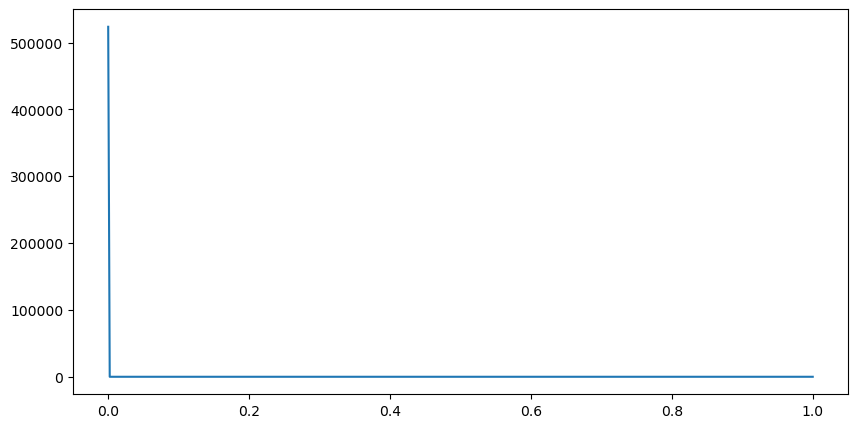

In [17]:
#let's see it plotted on a line plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(unique_vals[0], unique_vals[1])

In [19]:
#wait almost all 0 lol, but we want to see relative to where they are ones
masked_elems = out[1][:,-1].numpy() == 1
masked_values = values[masked_elems]
masked_values.shape

(2576,)

(0.0, 10.0)

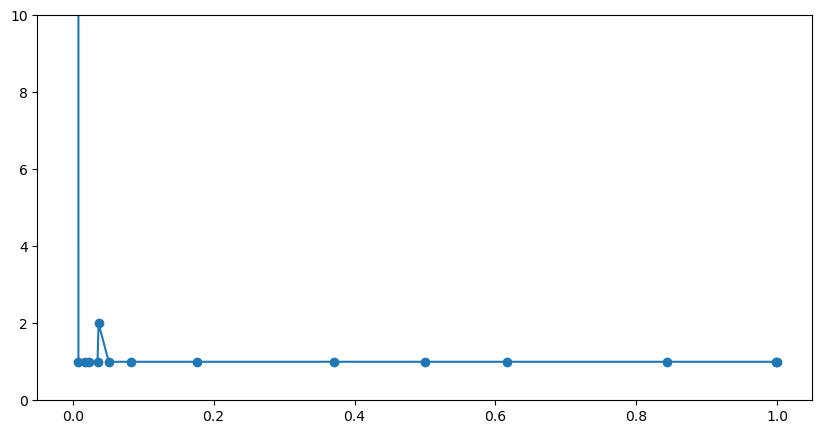

In [28]:
#now find unique elements and plot
unique_masked_vals = np.unique(masked_values, return_counts=True)
plt.figure(figsize=(10,5))
plt.plot(unique_masked_vals[0], unique_masked_vals[1],marker='o')
plt.ylim(0,10)

In [29]:
#yeah so it makes sense, finds these higher elements, masks them more, but I think we still need to let it find less elements to mask overall!

out = mask_seq(seqs, mask_pct=0.05, weights=torch.tensor(values, dtype=torch.float), span=1, return_probability_matrix=True, max_scale=10, weight_floor=0.001)

In [30]:
out[2]

tensor([0.0005, 0.0005, 0.0005,  ..., 0.0005, 0.0005, 0.0005],
       dtype=torch.float64)

In [31]:
#find how many masked
out[1][:,-1].sum()

tensor(309.)

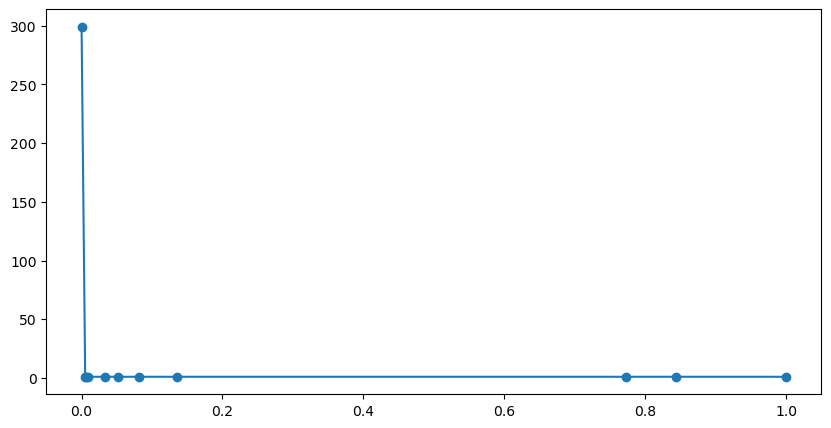

In [33]:
#now repeat the plot
masked_values = values[out[1][:,-1].numpy() == 1]
unique_masked_vals = np.unique(masked_values, return_counts=True)
plt.figure(figsize=(10,5))
plt.plot(unique_masked_vals[0], unique_masked_vals[1],marker='o')

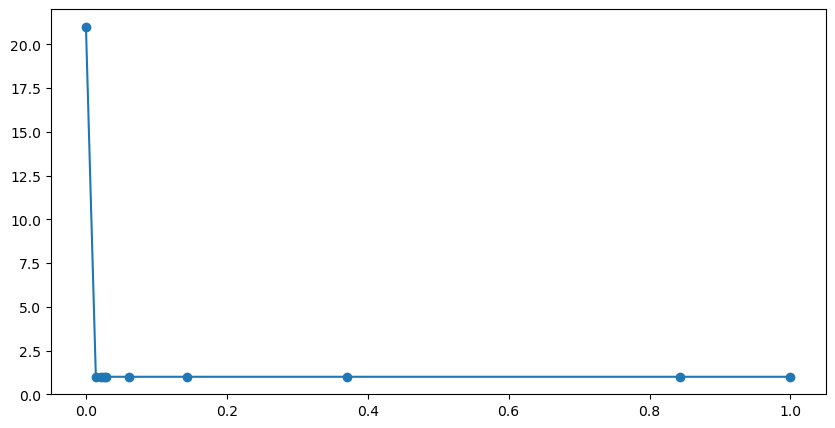

In [35]:
#and just a little bit lower
out = mask_seq(seqs, mask_pct=0.05, weights=torch.tensor(values, dtype=torch.float), span=1, return_probability_matrix=True, max_scale=10, weight_floor=0.0001)
masked_values = values[out[1][:,-1].numpy() == 1]
unique_masked_vals = np.unique(masked_values, return_counts=True)
plt.figure(figsize=(10,5))
plt.plot(unique_masked_vals[0], unique_masked_vals[1],marker='o')

In [ ]:
out[2].max() #so if definitely eQTL, 50% chance of mask! maybe that's too high still lol, make it like 35-40? so that would be like 0.05*X=0.35 -> X=7

tensor(0.5000, dtype=torch.float64)

In [38]:
out[2]

tensor([5.0000e-05, 5.0000e-05, 5.0000e-05,  ..., 5.0000e-05, 5.0000e-05,
        5.0000e-05], dtype=torch.float64)

In [39]:
#let's loop through seqs, get an idea of how many are masked
from tqdm import tqdm
masked_elems = []
weights_array = np.load('/data1/lesliec/sarthak/data/joint_playground/eQTL/GTEx/eqtl_pip_values_susie.npz')
weights_array_loaded = {}
for chrom in weights_array.files:
    weights_array_loaded[chrom] = weights_array[chrom]
    

for i in tqdm(range(seqs_file.shape[0])):
    temp = seqs_file.iloc[i]
    chrom = temp[0]
    start = temp[1]
    end = temp[2]
    #extend start and end to make length 524288
    start_ext = start - (524288 - (end - start))//2
    end_ext = end + (524288 - (end - start))//2

    #now let's grab these values from the weights array
    values = weights_array_loaded[chrom][start_ext:end_ext]

    #now let's see how this works with my mask seq function
    seqs = torch.ones((values.shape[0],4), dtype=torch.float)
    out = mask_seq(seqs, mask_pct=0.05, weights=torch.tensor(values, dtype=torch.float), span=1, return_probability_matrix=True, max_scale=10, weight_floor=0.0001)
    masked_elems.append(out[1][:,-1].numpy())

  0%|          | 10/38171 [00:00<16:34, 38.36it/s]


RuntimeError: Expected p_in >= 0 && p_in <= 1 to be true, but got false.  (Could this error message be improved?  If so, please report an enhancement request to PyTorch.)

In [ ]:
weights = torch.tensor(values, dtype=torch.float)
weights = (weights - weights.min()) / (weights.max() - weights.min() + 1e-6)
weights

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [45]:
floor = 0.0001
weights = floor + (1 - floor) * weights
weights

tensor([1.0000e-04, 1.0000e-04, 1.0000e-04,  ..., 1.0000e-04, 1.0000e-04,
        1.0000e-04])

# redo with fix

In [4]:
import sys
import torch
sys.path.append('/data1/lesliec/sarthak/caduceus/')
from src.dataloaders.utils.mask_seq import mask_seq
import numpy as np
from tqdm import tqdm
import pandas as pd
masked_elems = []
weights_array = np.load('/data1/lesliec/sarthak/data/joint_playground/eQTL/GTEx/eqtl_pip_values_susie.npz')
weights_array_loaded = {}
for chrom in weights_array.files:
    weights_array_loaded[chrom] = weights_array[chrom]
seqs_file = pd.read_csv('/data1/lesliec/sarthak/data/DK_zarr/sequences_enformer.bed', sep='\t', header=None)

for i in tqdm(range(seqs_file.shape[0])):
    temp = seqs_file.iloc[i]
    chrom = temp[0]
    start = temp[1]
    end = temp[2]
    #extend start and end to make length 524288
    start_ext = start - (524288 - (end - start))//2
    end_ext = end + (524288 - (end - start))//2
    if start_ext < 0 or end_ext > weights_array_loaded[chrom].shape[0]:
        #skip these regions
        # masked_elems.append(np.zeros((524288,), dtype=np.int8))
        continue

    #now let's grab these values from the weights array
    values = weights_array_loaded[chrom][start_ext:end_ext]

    #now let's see how this works with my mask seq function
    seqs = torch.ones((values.shape[0],4), dtype=torch.float)
    out = mask_seq(seqs, mask_pct=0.05, weights=torch.tensor(values, dtype=torch.float), span=1, return_probability_matrix=True, max_scale=10, weight_floor=0.0001)
    masked_elems.append(out[1][:,-1].numpy().sum())

 95%|█████████▌| 36440/38171 [14:05<00:40, 43.12it/s]


IndexError: too many indices for tensor of dimension 0

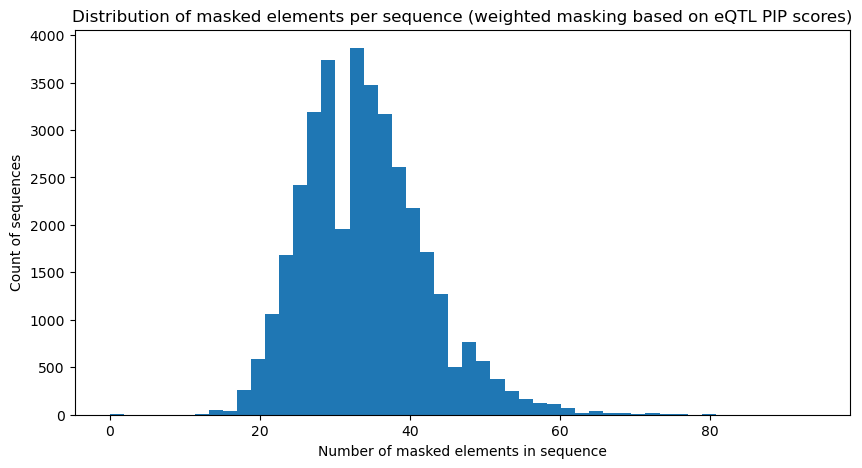

In [6]:
#do a plot of it
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.hist(masked_elems, bins=50)
plt.xlabel('Number of masked elements in sequence')
plt.ylabel('Count of sequences')
plt.title('Distribution of masked elements per sequence (weighted masking based on eQTL PIP scores)')
plt.show()

In [11]:
#ok it's a very small amount, but should be ok?
#see average is small
sum(masked_elems)/len(masked_elems)

34.02344630438965

In [ ]:
#so 35ish elements are masked, if we then scale down the loss because less stuff is masked, see that we get
35/ (524288*0.05) #scaled dwon by like 1000, so let's set count_weight to 0.1 instead of 16
#basially is scaled down by 1000, but so other one scaled down by 

0.00133514404296875

In [ ]:
#if we set reweight_loss to 0.001 instead, we get this
(524288*0.001)/35 #so now scaled down by 15 only, and that means that setting count_weight to 1.0 solves this issue

14.979657142857143

In [ ]:
#so basically for this PIP one based on number masked, count weight is 1, reweight_loss is 0.001

# fixed an issue in creating the values, let's redo it!

Also do it for the other two npy files to get this idea.

Can also do it for the phastcons npy files to get a better idea of what we're doing

100%|██████████| 38171/38171 [15:58<00:00, 39.81it/s]


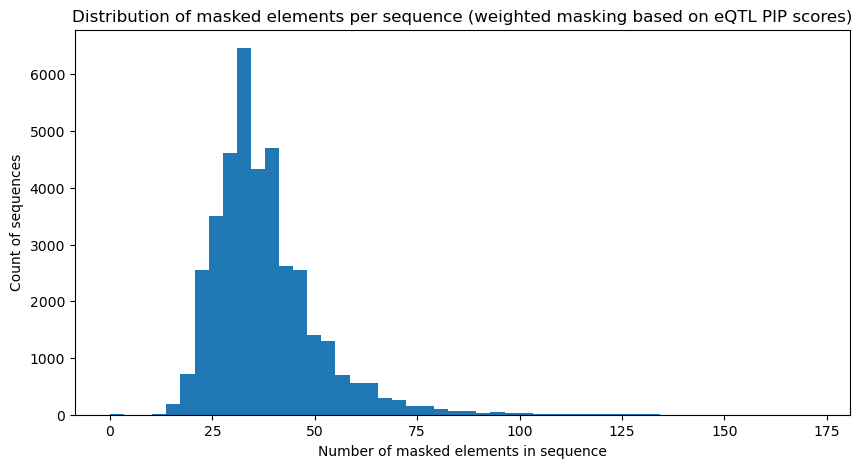

Average number of masked elements per sequence: 37.705022567439904


In [1]:
import sys
import torch
sys.path.append('/data1/lesliec/sarthak/caduceus/')
from src.dataloaders.utils.mask_seq import mask_seq
import numpy as np
from tqdm import tqdm
import pandas as pd
masked_elems = []
weights_array = np.load('/data1/lesliec/sarthak/data/joint_playground/eQTL/GTEx/eqtl_pip_values_susie.npz')
weights_array_loaded = {}
for chrom in weights_array.files:
    weights_array_loaded[chrom] = weights_array[chrom]
seqs_file = pd.read_csv('/data1/lesliec/sarthak/data/DK_zarr/sequences_enformer.bed', sep='\t', header=None)

for i in tqdm(range(seqs_file.shape[0])):
    temp = seqs_file.iloc[i]
    chrom = temp[0]
    start = temp[1]
    end = temp[2]
    #extend start and end to make length 524288
    start_ext = start - (524288 - (end - start))//2
    end_ext = end + (524288 - (end - start))//2
    if start_ext < 0 or end_ext > weights_array_loaded[chrom].shape[0]:
        #skip these regions
        # masked_elems.append(np.zeros((524288,), dtype=np.int8))
        continue

    #now let's grab these values from the weights array
    values = weights_array_loaded[chrom][start_ext:end_ext]

    #now let's see how this works with my mask seq function
    seqs = torch.ones((values.shape[0],4), dtype=torch.float)
    out = mask_seq(seqs, mask_pct=0.05, weights=torch.tensor(values, dtype=torch.float), span=1, return_probability_matrix=True, max_scale=10, weight_floor=0.0001)
    masked_elems.append(out[1][:,-1].numpy().sum())
    
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.hist(masked_elems, bins=50)
plt.xlabel('Number of masked elements in sequence')
plt.ylabel('Count of sequences')
plt.title('Distribution of masked elements per sequence (weighted masking based on eQTL PIP scores)')
plt.show()
#also print the mean
print(f'Average number of masked elements per sequence: {sum(masked_elems)/len(masked_elems)}')

In [3]:
#so if we are rescaling to make it 5%, (set reweight to 0.05), average of 37 total masked
print(f'normal masking rate: {524288*0.05}, reweight factor: {(524288*0.05)/37}') #so 700x less elements??

normal masking rate: 26214.4, reweight factor: 708.4972972972973


In [4]:
#let's set the value to 0.01 instead, so more reasonable?
print(f'normal masking rate: {524288*0.01}, reweight factor: {(524288*0.01)/37}') #so 140x less elements??

normal masking rate: 5242.88, reweight factor: 141.69945945945946


In [5]:
#and if set it to 0.001, we instead see that it is
print(f'normal masking rate: {524288*0.001}, reweight factor: {(524288*0.001)/37}') #so 14x less elements, then if count weight is 1, then it all balances out
#so just have to set reweight_loss to 0.001 and count_weight to 1.0 in the trainer

normal masking rate: 524.288, reweight factor: 14.169945945945946


100%|██████████| 38171/38171 [10:36<00:00, 59.93it/s] 


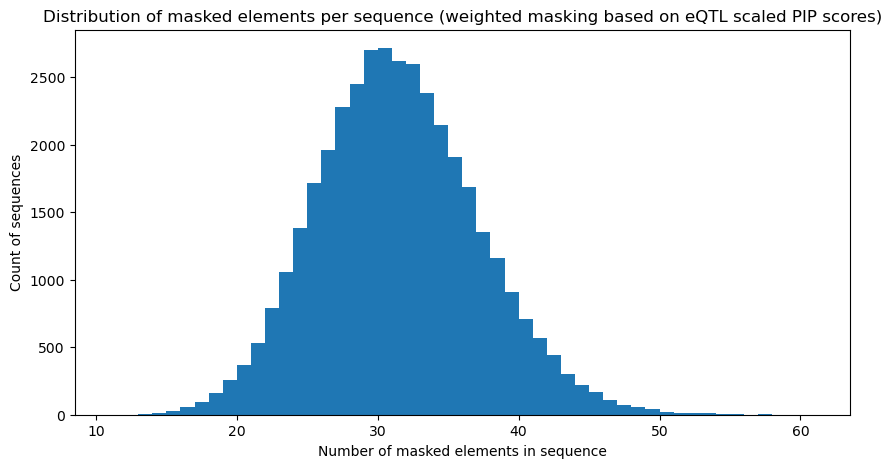

In [1]:
#we can also do it for the scaled values!
import sys
import torch
sys.path.append('/data1/lesliec/sarthak/caduceus/')
from src.dataloaders.utils.mask_seq import mask_seq
import numpy as np
from tqdm import tqdm
import pandas as pd
masked_elems = []
weights_array = np.load('/data1/lesliec/sarthak/data/joint_playground/eQTL/GTEx/eqtl_scaled_values_susie.npz')
weights_array_loaded = {}
for chrom in weights_array.files:
    weights_array_loaded[chrom] = weights_array[chrom]
seqs_file = pd.read_csv('/data1/lesliec/sarthak/data/DK_zarr/sequences_enformer.bed', sep='\t', header=None)

for i in tqdm(range(seqs_file.shape[0])):
    temp = seqs_file.iloc[i]
    chrom = temp[0]
    start = temp[1]
    end = temp[2]
    #extend start and end to make length 524288
    start_ext = start - (524288 - (end - start))//2
    end_ext = end + (524288 - (end - start))//2
    if start_ext < 0 or end_ext > weights_array_loaded[chrom].shape[0]:
        #skip these regions
        # masked_elems.append(np.zeros((524288,), dtype=np.int8))
        continue

    #now let's grab these values from the weights array
    values = weights_array_loaded[chrom][start_ext:end_ext]

    #now let's see how this works with my mask seq function
    seqs = torch.ones((values.shape[0],4), dtype=torch.float)
    out = mask_seq(seqs, mask_pct=0.05, weights=torch.tensor(values, dtype=torch.float), span=1, return_probability_matrix=True, max_neg_to_pos_ratio=0.1, binary_score_threshold=0.25)
    masked_elems.append(out[1][:,-1].numpy().sum())
    
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.hist(masked_elems, bins=50)
plt.xlabel('Number of masked elements in sequence')
plt.ylabel('Count of sequences')
plt.title('Distriibution of masked elements per sequence (weighted masking based on eQTL scaled PIP scores)')
plt.show()

In [3]:
print(f'Average number of masked elements per sequence: {sum(masked_elems)/len(masked_elems)}')

Average number of masked elements per sequence: 30.943450194184948


In [5]:
#slightly edited mask seq, let's see how it looks if we intentionally make nothing masked
import sys
import torch
sys.path.append('/data1/lesliec/sarthak/caduceus/')
from src.dataloaders.utils.mask_seq import mask_seq
import numpy as np
from tqdm import tqdm
import pandas as pd
masked_elems = []
weights_array = np.load('/data1/lesliec/sarthak/data/joint_playground/eQTL/GTEx/eqtl_scaled_values_susie.npz')
weights_array_loaded = {}
for chrom in weights_array.files:
    weights_array_loaded[chrom] = weights_array[chrom]
seqs_file = pd.read_csv('/data1/lesliec/sarthak/data/DK_zarr/sequences_enformer.bed', sep='\t', header=None)

for i in tqdm(range(seqs_file.shape[0])):
    temp = seqs_file.iloc[i]
    chrom = temp[0]
    start = temp[1]
    end = temp[2]
    #extend start and end to make length 524288
    start_ext = start - (524288 - (end - start))//2
    end_ext = end + (524288 - (end - start))//2
    if start_ext < 0 or end_ext > weights_array_loaded[chrom].shape[0]:
        #skip these regions
        # masked_elems.append(np.zeros((524288,), dtype=np.int8))
        continue

    #now let's grab these values from the weights array
    values = weights_array_loaded[chrom][start_ext:end_ext]

    #now let's see how this works with my mask seq function
    seqs = torch.ones((values.shape[0],4), dtype=torch.float)
    out = mask_seq(seqs, mask_pct=0.05, weights=torch.tensor(values*0, dtype=torch.float), span=1, return_probability_matrix=True, max_neg_to_pos_ratio=0.1, binary_score_threshold=0.25, minimum_neg_masks=0)
    masked_elems.append(out[1][:,-1].numpy().sum())
    break

  0%|          | 0/38171 [00:00<?, ?it/s]


In [7]:
out[2].sum() #nothing will be masked

tensor(0.)

In [8]:
out[1]

tensor([[1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        ...,
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.]])

In [9]:
out[0]

tensor([[1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        ...,
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.]])

In [10]:
#let's make sure the same as when we set that max neg to a higher value
out = mask_seq(seqs, mask_pct=0.05, weights=torch.tensor(values*0, dtype=torch.float), span=1, return_probability_matrix=True, max_neg_to_pos_ratio=0.1, binary_score_threshold=0.25, minimum_neg_masks=30)

In [11]:
out[0]

tensor([[1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        ...,
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.]])

In [13]:
out[1]

tensor([[1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        ...,
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.]])

In [17]:
out[1].sum(0) #yeah ok this seems about right!! 

tensor([5.2429e+05, 5.2429e+05, 5.2429e+05, 5.2429e+05, 2.9000e+01])

In [12]:
out[2].sum()

tensor(30.)

In [2]:
3

3

In [ ]:
#can also set a threshold for these scaled values, set like 0.2 so it is a somewhat likely eqtl, but onlyh like 0.05 for 

100%|██████████| 38171/38171 [09:32<00:00, 66.65it/s]


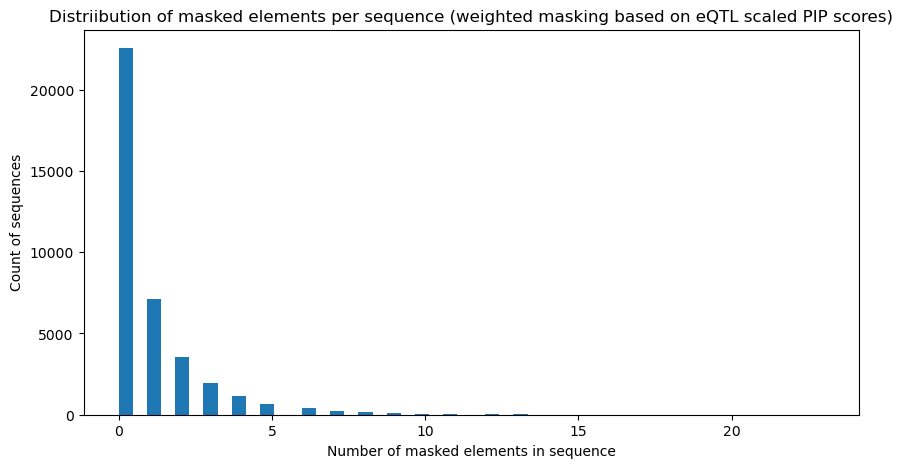

Average number of masked elements per sequence: 0.9617927994121969


In [1]:
#what if we intentionally set the minimum number to be 0, that way it can ignore mlm of sampleswhere there's no qtl type elements!
#we can also do it for the scaled values!
import sys
import torch
sys.path.append('/data1/lesliec/sarthak/caduceus/')
from src.dataloaders.utils.mask_seq import mask_seq
import numpy as np
from tqdm import tqdm
import pandas as pd
masked_elems = []
weights_array = np.load('/data1/lesliec/sarthak/data/joint_playground/eQTL/GTEx/eqtl_scaled_values_susie.npz')
weights_array_loaded = {}
for chrom in weights_array.files:
    weights_array_loaded[chrom] = weights_array[chrom]
seqs_file = pd.read_csv('/data1/lesliec/sarthak/data/DK_zarr/sequences_enformer.bed', sep='\t', header=None)

for i in tqdm(range(seqs_file.shape[0])):
    temp = seqs_file.iloc[i]
    chrom = temp[0]
    start = temp[1]
    end = temp[2]
    #extend start and end to make length 524288
    start_ext = start - (524288 - (end - start))//2
    end_ext = end + (524288 - (end - start))//2
    if start_ext < 0 or end_ext > weights_array_loaded[chrom].shape[0]:
        #skip these regions
        # masked_elems.append(np.zeros((524288,), dtype=np.int8))
        continue

    #now let's grab these values from the weights array
    values = weights_array_loaded[chrom][start_ext:end_ext]

    #now let's see how this works with my mask seq function
    seqs = torch.ones((values.shape[0],4), dtype=torch.float)
    out = mask_seq(seqs, mask_pct=0.05, weights=torch.tensor(values, dtype=torch.float), span=1, return_probability_matrix=True, max_neg_to_pos_ratio=0.1, binary_score_threshold=0.25, minimum_neg_masks=0)
    masked_elems.append(out[1][:,-1].numpy().sum())
    
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.hist(masked_elems, bins=50)
plt.xlabel('Number of masked elements in sequence')
plt.ylabel('Count of sequences')
plt.title('Distriibution of masked elements per sequence (weighted masking based on eQTL scaled PIP scores)')
plt.show()
print(f'Average number of masked elements per sequence: {sum(masked_elems)/len(masked_elems)}')

In [ ]:
#but I'm ok weighting this more since masked elements are mainly eQTLs!! but the basic weighting wil weight it less, so we set baseline to higher
print(f'normal masking rate: {524288*0.05}, reweight factor: {(524288*0.00001)/1}') #so use this rate for this one

normal masking rate: 26214.4, reweight factor: 5.24288


In [ ]:
#finally something is messed up about maskseq when there's 0 elements, let's see what the difference is?

#i kind of like tha tmany examples wher eno sequence masking, means that when it's masked, it's important, and model can learn to ginore when not